In [19]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.ensemble import IsolationForest
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd


In [32]:
# Charger le jeu de données 20newsgroups
data = fetch_20newsgroups()

# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test = train_test_split(data.data, test_size=0.2, random_state=42)

# Créer une représentation vectorielle des documents
vectorizer = CountVectorizer(max_features=1000, max_df=0.5, min_df=2, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [31]:
###################### Modèle LDA
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(X_train_vectorized)

# Attribuer les documents de l'ensemble d'entraînement à des sujets
train_topic_assignments_lda = lda.transform(X_train_vectorized)

# Attribuer les documents de l'ensemble de test à des sujets
test_topic_assignments_lda = lda.transform(X_test_vectorized)

# Calculer le score de silhouette pour LDA
silhouette_lda = silhouette_score(test_topic_assignments_lda, test_topic_assignments_lda.argmax(axis=1))
print(f"Silhouette LDA Score: {silhouette_lda}")

# Utiliser le modèle IsolationForest pour évaluer la pertinence de l'entraînement sur les données de test
isolation_forest = IsolationForest(random_state=42)
isolation_forest.fit(test_topic_assignments_lda)
outliers_lda = isolation_forest.predict(test_topic_assignments_lda)
outlier_percentage_lda = list(outliers_lda).count(-1) / len(outliers_lda)
print(f"Outlier Percentage: {outlier_percentage_lda}")

topic_word_distributions_lda = lda.components_
topics = []
for topic_idx, topic_words in enumerate(topic_word_distributions_lda):
    top_words = [list(vectorizer.vocabulary_.keys())[i] for i in topic_words.argsort()[:-6:-1]]
    topics.append(', '.join(top_words))



Silhouette LDA Score: 0.2838784449516586
Outlier Percentage: 0.0


In [31]:
############################ Modèle Kmean
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( #Convert a collection of raw documents to a matrix of TF-IDF features
    max_df=0.5,
    min_df=5,
    stop_words="english",
    max_features=1000,
)
X_train_vectorized = vectorizer.fit_transform(data.data) 

kmeans_ = KMeans(n_clusters=20,max_iter=100,)

kmeans_.fit(X_train_vectorized)

# Attribuer les documents de l'ensemble d'entraînement à des sujets
train_topic_assignments_K = kmeans_.transform(X_train_vectorized)

# Attribuer les documents de l'ensemble de test à des sujets
test_topic_assignments_K = kmeans_.predict(X_test_vectorized)

# Calculer le score de silhouette pour KMeans
silhouette_kmean = silhouette_score(X_train_vectorized, kmeans_.labels_)
print(f"Silhouette Kmean Score: {silhouette_kmean}")

# Utiliser le modèle IsolationForest pour évaluer la pertinence de l'entraînement sur les données de test
isolation_forest = IsolationForest(random_state=42)
isolation_forest.fit(train_topic_assignments_K)
outliers_k = isolation_forest.predict(train_topic_assignments_K)
outlier_percentage_k = list(outliers_k).count(-1) / len(outliers_k)
print(f"Outlier Percentage: {outlier_percentage_k}")

topic_word_distributions_k = kmeans_.cluster_centers_
topics = []
for topic_idx, topic_words_k in enumerate(topic_word_distributions_k):
    top_words_k = [list(vectorizer.get_feature_names_out())[i] for i in topic_words_k.argsort()[:-6:-1]]
    topics.append(', '.join(top_words_k))
    

c:\Users\Elion\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Kmean Score: 0.020541801962079845
Outlier Percentage: 0.0069510771516502175


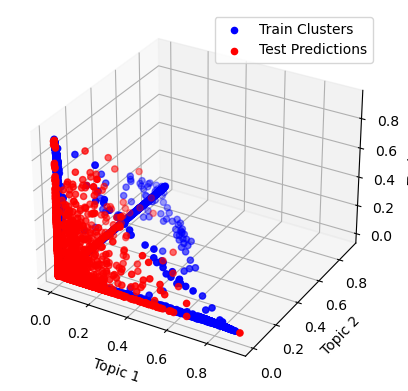

In [22]:
# Visualiser les clusters d'entraînement et les prédictions sur les données de test en 3D Statique
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Coordonnées des sujets d'entraînement
train_x = train_topic_assignments_lda[:, 0]
train_y = train_topic_assignments_lda[:, 1]
train_z = train_topic_assignments_lda[:, 2]
ax.scatter(train_x, train_y, train_z, c='blue', label='Train Clusters')

# Coordonnées des sujets de test
test_x = test_topic_assignments_lda[:, 0]
test_y = test_topic_assignments_lda[:, 1]
test_z = test_topic_assignments_lda[:, 2]
ax.scatter(test_x, test_y, test_z, c='red', label='Test Predictions')

ax.set_xlabel('Topic 1')
ax.set_ylabel('Topic 2')
ax.set_zlabel('Topic 3')
ax.legend()

plt.show()

In [27]:
# Visualiser les clusters d'entraînement et les prédictions sur les données de test en 3D
# Créer les coordonnées x, y et z pour chaque point de données
x_train = train_topic_assignments_lda[:, 0]
y_train = train_topic_assignments_lda[:, 1]
z_train = train_topic_assignments_lda[:, 2]

x_test = test_topic_assignments_lda[:, 0]
y_test = test_topic_assignments_lda[:, 1]
z_test = test_topic_assignments_lda[:, 2]

# Afficher les clusters trouvés lors de l'entraînement en 3D
lda_labels = KMeans(n_clusters=10, random_state=0).fit_predict(train_topic_assignments_lda)

fig = go.Figure(data=[
    go.Scatter3d(x=x_train, y=y_train, z=z_train, mode='markers', marker=dict(size=2, opacity=0.7, color=lda_labels),name='Train'),
    go.Scatter3d(x=x_test, y=y_test, z=z_test, mode='markers', marker=dict(size=2, opacity=0.7, color=lda_labels),name='Test')
])
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

fig.show()


c:\Users\Elion\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# Visualiser les clusters d'entraînement et les prédictions sur les données de test en 3D
# Créer les coordonnées x, y et z pour chaque point de données
x_train = train_topic_assignments_K[:, 0]
y_train = train_topic_assignments_K[:, 1]
z_train = train_topic_assignments_K[:, 2]

x_test = test_topic_assignments_K[:, 0]
y_test = test_topic_assignments_K[:, 1]
z_test = test_topic_assignments_K[:, 2]

# Afficher les clusters trouvés lors de l'entraînement en 3D
cluster_labels = KMeans(n_clusters=10, random_state=0).fit_predict(train_topic_assignments_K)

fig = go.Figure(data=[
    go.Scatter3d(x=x_train, y=y_train, z=z_train, mode='markers', marker=dict(size=2, opacity=0.7, color=cluster_labels),name='Train'),
    go.Scatter3d(x=x_test, y=y_test, z=z_test, mode='markers', marker=dict(size=2, opacity=0.7, color=cluster_labels),name='Test')
])
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
# fig.(*cluster_labels.item(), title='Clusters')
fig.show()


In [30]:
dataset = fetch_20newsgroups()
df = pd.DataFrame()
df["data"] = dataset["data"]
df["target"] = dataset["target"]
df["target_names"] = df.target.apply(lambda row: dataset["target_names"][row])
df.head()

def clean_text(text):
    return " ".join([ Word(word).lemmatize() for word in re.sub("[^A-Za-z0-9]+", " ", text).lower().split() if word not in stopword])    

df["data_str"] = df.data.apply(lambda row: clean_text(row) )

NameError: name 'stopwords' is not defined

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns

perp_components = defaultdict(dict)
for i in [10,30,50,100]:
    for ngram in [(1,1),(1,2),(1,3),(2,2),(3,3)]:
        vectorizer = TfidfVectorizer(ngram_range=ngram, max_features= 2**10)
        text_to_vector = vectorizer.fit_transform(data.data_str.values)
        print("Ngram ",ngram )
        print("Perplexity ", i)
        X_embedded = TSNE(init="random",perplexity=i ).fit_transform(text_to_vector)
        ngram_str = str(ngram[0])+"_"+str(ngram[1])
        perp_components[i][ngram_str] = X_embedded
        # sns settings
        sns.set(rc={'figure.figsize':(15,15)})
        # colors
        palette = sns.color_palette("hls", len(set(df.target_names.values.tolist())))        
        y = df.target_names.values.tolist()
        # plot
        sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
        title = "t-SNE- 20News group - TfIdf - "+ngram_str+"- tSNE perplexity - "+str(i)
        plt.savefig(title)
        plt.title(title)
        plt.show()

AttributeError: apply